# **Preinstallation and upload**

In [ ]:
pip install opencv-python==4.4.0.46 opencv-contrib-python==4.4.0.40

     |████████████████████████████████| 49.5MB 96kB/s 
     |████████████████████████████████| 55.6MB 81kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
file_id="1qAD7StpMovQM2u8g6kgf9CysYs-vZ-P-"
!gdown https://drive.google.com/uc?id={file_id}



!unzip -q datasetProjetS5_2020.zip

Downloading...
From: https://drive.google.com/uc?id=1qAD7StpMovQM2u8g6kgf9CysYs-vZ-P-
To: /content/datasetProjetS5_2020.zip
864MB [00:08, 103MB/s] 


In [ ]:
!rm -rf /content/datasetProjetS5_2020/test/Background_without_leaves
!rm -rf /content/datasetProjetS5_2020/train/Background_without_leaves
!rm -rf /content/datasetProjetS5_2020/valid/Background_without_leaves

# **Importations and Methods**

importations

In [ ]:
#---------sklearn importations------------#
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.externals import joblib

#------------tracage des courbes-----------#
import matplotlib.pyplot as plt

#-------------cv2 de openCv -----------#
import cv2

#--------------importation des données----#
import os

#-----------calcule arithmetique---------#
import numpy as np


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Methods

In [ ]:
def max_rgb_filter(image):
	# split the image into its BGR components
	(B, G, R) = cv2.split(image)
	# find the maximum pixel intensity values for each
	# (x, y)-coordinate,, then set all pixel values less
	# than M to zero
	M = np.maximum(np.maximum(R, G), B)
	R[R < M] = 0
	G[G < M] = 0
	B[B < M] = 0
	# merge the channels back together and return the image
	return cv2.merge([B, G, R])

In [ ]:
def progress(percent=0, width=30,smth=""):
    left = width * percent // 100
    right = width - left
    print('\r',smth,' : [', '#' * left, ' ' * right, ']',
          f' {percent:.0f}%',
          sep='', end='', flush=True)

In [ ]:
def importData(dataType,nbreClass):
  print("------------------------------------------")
  #---------Array contenant les noms des repertoires/classes------#
  target = os.listdir('datasetProjetS5_2020/'+dataType)
  target.sort()
  #----------------------------------------------------------------#
  #-data_name contenire le path de chaque image et targets la classe correspondante-#
  data_name=[]
  targets=[]
  #-----la premiere boucle pour passer sur les classes-------#
  for i in range(nbreClass):
    #-----------avoir touts les noms des images de la classe i---------#
    sous_image_names=os.listdir('datasetProjetS5_2020/'+dataType+'/'+target[i])
    sous_image_names.sort()
    #------------------------------------------------------------------#

    #-----la deuxieme boucle pour passer sur touts les images de la classe i-------#
    for j in range(len(sous_image_names)):
      #-----array contenant touts le path des images de la classe i-------#
        sous_image_names[j]='datasetProjetS5_2020/'+dataType+'/'+target[i]+'/'+sous_image_names[j]
        #---le nom de la classe correspondante a l'image est ajouter à targets---#
        targets.append(target[i])
        #---le nom de l'image est lui aussi ajouter a data_name--#
        data_name.append(sous_image_names[j])
        #--------------------------------------------------------#

  data=[]
  #----cette boucle pour recuperer physiquement les photos----#
  for k in range(len(data_name)):
    #------------affiche une progress bar--------------#
    progress(int(k*(100/len(data_name)))+1,30,"Importation of data")
    #--extraire image en gris grace au path deja trouver------#
    img =cv2.imread(str(data_name[k]),cv2.IMREAD_GRAYSCALE)
#------------------------partie des filtres-----------------------------#
    img = cv2.GaussianBlur(img,(3,3),1)
    #img = cv2.bilateralFilter(img,3,3,3)

    #img = cv2.Canny(img,250,250)
    #img = cv2.Canny(img,100,200)
    #img = cv2.bilateralFilter(img,5,20,100,borderType = cv2.BORDER_CONSTANT)

    #img = cv2.bilateralFilter(img,9,75,75)

    #img = cv2.bilateralFilter(img,3,3,3)
    #img = cv2.GaussianBlur(img,(3,3),1)

    #img = max_rgb_filter(img)
    #img = cv2.bilateralFilter(img,3,3,3)
    #img = cv2.Laplacian(img,cv2.CV_64F, ksize=3)
    #img = cv2.equalizeHist(img)
#-----------------------------------------------------------------------#
    data.append(img)
  print("\n------------------Done------------------")
  return data ,targets

In [ ]:
def getTargets(dataType,nbreClass):
  print("Importation of targets")
  #------mettre les noms des classes dans target------#
  target = os.listdir('datasetProjetS5_2020/'+dataType)
  target.sort()
  #------on prend qu'un exemplaire de classes----#
  target_sample=[0]*nbreClass
  for i in range(nbreClass):
    target_sample[i]=target[i]
  print("------------------Done------------------")
  #--------- retourne exemplaire de classes----#
  return target_sample

In [ ]:
 def setElementReady(typeData,target,data,nbreClass):
   #----declaration----#
  dictionary = []
  #---objet sift---#
  sift=cv2.SIFT_create()
  #---objet qui calcule le kmeans des features---#
  indiceNonValide=[]
  to=0

  #-----la premiere boucle pour passer sur les classes-------#
  for i in range(0,nbreClass):
    fr=to
    to=to+len(os.listdir('datasetProjetS5_2020/'+typeData+'/'+target[i]))
    print("---class num", i+1,"---")
    print("from :",fr+1)
    print("to :",to)
    print("nbre element :",to-fr)

    #-----la deuxieme boucle pour passer sur touts les images de la classe i-------#
    for j in range(fr,to):
        progress(int((j-fr)*(100/(to-fr)))+1,30,"detection of features : "+target[i])
        #------------detecter les features de l'image j de la classe i-----#
        BOW = cv2.BOWKMeansTrainer(1)
        kp , ft = sift.detectAndCompute(data[j],None)
        if(ft is not None):
          BOW.add(ft)
          dictionary.append(BOW.cluster())
        else :
          indiceNonValide.append(j)
    print()
  print("---------DONE------------")
  #---retourne le dictionaire----#
  return dictionary,indiceNonValide

In [ ]:
def setTargetsNumbers(targets):
  train_labels=[]
  class_index = -1
  for target in targets:
        if("""Apple___Apple_scab""" == target):
            class_index = 0
        elif("""Apple___Black_rot""" == target):
            class_index = 1
        elif("""Apple___Cedar_apple_rust""" == target):
            class_index = 2
        elif("""Apple___healthy""" == target):
            class_index = 3
        elif("Blueberry___healthy" == target):
            class_index = 4
        elif("Cherry___healthy" == target):
          class_index = 5
        elif("Cherry___Powdery_mildew" == target):
          class_index = 6
        elif("Corn___Cercospora_leaf_spot Gray_leaf_spot" == target):
          class_index = 7
        elif("Corn___Common_rust" == target):
          class_index = 8
        elif("Corn___healthy" == target):
          class_index = 9
        elif("Corn___Northern_Leaf_Blight" == target):
          class_index = 10
        elif("Grape___Black_rot" == target):
          class_index = 11
        elif("Grape___Esca_(Black_Measles)" == target):
          class_index = 12
        elif("Grape___healthy" == target):
          class_index = 13
        elif("Grape___Leaf_blight_(Isariopsis_Leaf_Spot)" == target):
          class_index = 14
        elif("Orange___Haunglongbing_(Citrus_greening)" == target):
          class_index = 15
        elif("Peach___Bacterial_spot" == target):
          class_index = 16
        elif("Peach___healthy" == target):
          class_index = 17
        elif("Pepper,_bell___Bacterial_spot" == target):
          class_index = 18
        elif("Pepper,_bell___healthy" == target):
          class_index = 19
        elif("Potato___Early_blight" == target):
          class_index = 20
        elif("Potato___healthy" == target):
          class_index = 21
        elif("Potato___Late_blight" == target):
          class_index = 22
        elif("Raspberry___healthy" == target):
          class_index = 23
        elif("Soybean___healthy" == target):
          class_index = 24
        elif("Squash___Powdery_mildew" == target):
          class_index = 25
        elif("Strawberry___healthy" == target):
          class_index = 26
        elif("Strawberry___Leaf_scorch" == target):
          class_index = 27
        elif("Tomato___Bacterial_spot" == target):
          class_index = 28
        elif("Tomato___Early_blight" == target):
          class_index = 29
        elif("Tomato___healthy" == target):
          class_index = 30
        elif("Tomato___Late_blight" == target):
          class_index = 31
        elif("Tomato___Leaf_Mold" == target):
          class_index = 32
        elif("Tomato___Septoria_leaf_spot" == target):
          class_index = 33
        elif("Tomato___Spider_mites Two-spotted_spider_mite" == target):
          class_index = 34
        elif("Tomato___Target_Spot" == target):
          class_index = 35
        elif("Tomato___Tomato_mosaic_virus" == target):
          class_index = 36
        elif("Tomato___Tomato_Yellow_Leaf_Curl_Virus" == target):
          class_index = 37
        train_labels.append(class_index)
  return train_labels

In [ ]:
def removeBadSizedImages(x,y,nbreBad): 
  for i in range(len(x)-nbreBad-1,0,-1):
    if(len(x[i][0])!=128):
      x.pop(i)
      y.pop(i)


In [ ]:
def getNumBadSizedImages(x):
  bad=[]
  print("lenght :",len(x))
  for i in range(len(x)):
    if(len(x[i][0])!=128):
      bad.append(i)

  return len(bad)

In [ ]:
def removeEleByList(x,nv):
  nv.reverse()
  for i in nv:
    print("removing bad id:",i)
    x.pop(i)
  return x

In [ ]:
def executeTrain(x_train,y_train):
  svc = SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=1, kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
  svc.fit(x_train,y_train)
  print(svc)
  return svc

In [ ]:
def getXY(dataType,nbreClass):

  #----------------data importation---------------------#
  data_test,targets_test=importData(dataType,nbreClass)
  ytest=getTargets(dataType,nbreClass)
  #--------------end data importation-------------------#

  #----------------cleaning xtest ytest-----------------#
  #from classes to id
  targets_test= setTargetsNumbers(targets_test)
  y_test=targets_test
  #get the form of testing
  x_test,y_test_nvid=setElementReady(dataType,ytest,data_test,nbreClass)
  #remove element that didnt get the testing form 
  y_test=removeEleByList(y_test,y_test_nvid)
  #detect and remove it bad sized images
  nbreBad= getNumBadSizedImages(x_test)
  removeBadSizedImages(x_test,y_test,nbreBad)
  #from 3d to 2d
  for i in range(len(x_test)):
    x_test[i]=x_test[i][0]
  #x_test = np.array(x_test).reshape(len(y_test),128)
  #-------------end cleaning xtest ytest----------------#

  return x_test,y_test

In [ ]:
def executeTest(x_test,y_test,svc):
  resultat=svc.predict(x_test)
  score = svc.score(x_test, y_test)
  print()
  print("--------------------------------score and ploting confusing matrix------------------------------")
  print()
  accuracy = accuracy_score(y_test, resultat)
  print ("accuracy = ", accuracy)
  cm = confusion_matrix(y_test, resultat)
  plt.matshow(cm)
  plt.title('Confusion matrix')
  plt.colorbar()
  plt.show()

In [ ]:
def getTargetByImage(path,svm):
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = cv2.GaussianBlur(img,(3,3),1)
    x_test=[]
    resultat = -1
    sift=cv2.SIFT_create()
    BOW = cv2.BOWKMeansTrainer(1)
    kp , ft = sift.detectAndCompute(img,None)
    if(ft is not None):
      BOW.add(ft)
      x_test=BOW.cluster()
      resultat=svc.predict(x_test)
    else:
      print("cannot get the right shape")

    targets=getTargets("train",38)
    return targets[resultat[0]]


# **Training**

In [ ]:
x_train, y_train=getXY("train",38)

------------------------------------------
Importation of data : [##############################] 100%
------------------Done------------------
Importation of targets
------------------Done------------------
---class num 1 ---
from : 1
to : 403
nbre element : 403
detection of features : Apple___Apple_scab : [##############################] 100%
---class num 2 ---
from : 404
to : 803
nbre element : 400
detection of features : Apple___Black_rot : [##############################] 100%
---class num 3 ---
from : 804
to : 967
nbre element : 164
detection of features : Apple___Cedar_apple_rust : [##############################] 100%
---class num 4 ---
from : 968
to : 2020
nbre element : 1053
detection of features : Apple___healthy : [##############################] 100%
---class num 5 ---
from : 2021
to : 2979
nbre element : 959
detection of features : Blueberry___healthy : [##############################] 100%
---class num 6 ---
from : 2980
to : 3655
nbre element : 676
detection of features 

In [ ]:
svc=executeTrain(x_train,y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=1, kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


# **Testing**


**Get score**

In [ ]:
x_test,y_test=getXY("test",38)

------------------------------------------
Importation of data : [##############################] 100%
------------------Done------------------
Importation of targets
------------------Done------------------
---class num 1 ---
from : 1
to : 127
nbre element : 127
detection of features : Apple___Apple_scab : [##############################] 100%
---class num 2 ---
from : 128
to : 251
nbre element : 124
detection of features : Apple___Black_rot : [##############################] 100%
---class num 3 ---
from : 252
to : 306
nbre element : 55
detection of features : Apple___Cedar_apple_rust : [############################# ] 99%
---class num 4 ---
from : 307
to : 635
nbre element : 329
detection of features : Apple___healthy : [##############################] 100%
---class num 5 ---
from : 636
to : 936
nbre element : 301
detection of features : Blueberry___healthy : [##############################] 100%
---class num 6 ---
from : 937
to : 1147
nbre element : 211
detection of features : Cherr


--------------------------------score and ploting confusing matrix------------------------------

accuracy =  0.7477243172951885


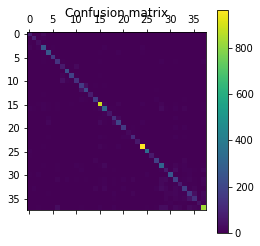

In [ ]:
executeTest(x_test,y_test,svc)

In [ ]:
#G = 84.5988
#B = 86.37
#G + B = 84.97
#B + B = 85.46
#rien = 85.46
#gris = 85.89
#gris + G = 

**Test by image**




In [ ]:
path = "/content/datasetProjetS5_2020/valid/Apple___Black_rot/image (407).JPG"

resultat = getTargetByImage(path,svc)
print("resultat predit =",resultat)

Importation of targets
------------------Done------------------
resultat predit = Apple___Black_rot


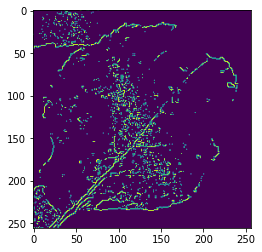

In [ ]:
path = "/content/datasetProjetS5_2020/valid/Apple___Black_rot/image (407).JPG"
img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
#img = cv2.GaussianBlur(img,(3,3),1)
#img = cv2.GaussianBlur(img,(5,5),1)
#img = cv2.bilateralFilter(img,3,3,3)
#img = cv2.bilateralFilter(img,5,20,100,borderType = cv2.BORDER_CONSTANT)
img = cv2.Canny(img,250,250)
#img = cv2.Canny(img,100,200)
#img = cv2.Canny(img,100,200)
#img = cv2.equalizeHist(img)
#img = cv2.equalizeHist(img)
#img = cv2.Laplacian(img,cv2.CV_64F, ksize=3)
#img = max_rgb_filter(img)
kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(img,-1,kernel)
median = cv2.medianBlur(img,5)
blur = cv2.blur(img,(5,5))
plt.imshow(img)

#**Validation**

------------------------------------------
Importation of data : [##############################] 100%
------------------Done------------------
Importation of targets
------------------Done------------------
---class num 1 ---
from : 1
to : 100
nbre element : 100
detection of features : Apple___Apple_scab : [##############################] 100%
---class num 2 ---
from : 101
to : 197
nbre element : 97
detection of features : Apple___Black_rot : [############################# ] 99%
---class num 3 ---
from : 198
to : 253
nbre element : 56
detection of features : Apple___Cedar_apple_rust : [############################# ] 99%
---class num 4 ---
from : 254
to : 516
nbre element : 263
detection of features : Apple___healthy : [##############################] 100%
---class num 5 ---
from : 517
to : 758
nbre element : 242
detection of features : Blueberry___healthy : [##############################] 100%
---class num 6 ---
from : 759
to : 923
nbre element : 165
detection of features : Cherry__

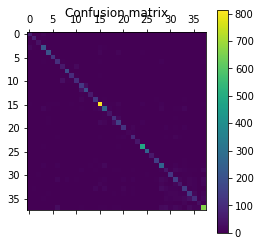

In [ ]:
x_valid,y_valid = getXY("valid",38)

executeTest(x_valid , y_valid ,svc)

#**Finding best params for svm**

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
param_grid = {'C': [1,10],
              'gamma': [1,0.1],
              'kernel': ['rbf','poly'],
              'decision_function_shape' :['ovo'],
              'class_weight' :['balanced']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=200,return_train_score=True,
                    iid=True,n_jobs=-1,cv=StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42))
grid.fit(x_train,y_train)
print("best Estimator : ",grid.best_estimator_)
print("best score : ",grid.best_score_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 47.4min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 58.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 58.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 76.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 76.9min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 88.2min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 88.4min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 106.9min
[Parallel(n_jobs=-1)]: Done  14 out of  16 | elapsed: 107

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


best Estimator :  SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
best score :  0.6726241134751773


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
param_grid = {'C': [0.1],
              'gamma': [1],
              'kernel': ['poly'],
              'decision_function_shape' :['ovo'],
              'class_weight' :['balanced'],
              'degree' :[3],
              'coef0' :[0,1,2,3,4,5,6]
              }
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=100,return_train_score=True,
                    iid=True,n_jobs=-1,cv=StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42))
grid.fit(x_train,y_train)
print("best Estimator : ",grid.best_estimator_)
print("best score : ",grid.best_score_)

Fitting 2 folds for each of 7 candidates, totalling 14 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed: 32.2min remaining:  5.4min
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed: 37.6min remaining:    0.0s
[Parallel(n_jobs=-1)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


best Estimator :  SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0,
    decision_function_shape='ovo', degree=3, gamma=1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
best score :  0.7468426280686817


#**Save or Import the Svm**

In [ ]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.22.2.post1.


In [ ]:
svc = joblib.load("/content/drive/MyDrive/Colab Notebooks/BestSVM.pkl")

In [ ]:
joblib.dump((svc), "BestSVM.pkl", compress=3) 

['BestSVM.pkl']

#**Unused Functions**

In [ ]:
 def getVisualWords(typeData,target,data,nbreClass):
   #----declaration----#
  dictionary = []
  #---objet sift---#
  sift=cv2.SIFT_create()
  #---objet qui calcule le kmeans des features---#
  BOW = cv2.BOWKMeansTrainer(nbreClass)
  to=0

  #-----la premiere boucle pour passer sur les classes-------#
  for i in range(0,nbreClass):
    fr=to
    to=to+len(os.listdir('datasetProjetS5_2020/'+typeData+'/'+target[i]))
    print("---class num", i+1,"---")
    print("from :",fr+1)
    print("to :",to)
    print("nbre element :",to-fr)

    #-----la deuxieme boucle pour passer sur touts les images de la classe i-------#
    for j in range(fr,to):
        progress(int((j-fr)*(100/(to-fr)))+1,30,"detection of features : "+target[i])
        #------------detecter les features de l'image j de la classe i-----#
        kp , ft = sift.detectAndCompute(data[j],None)
        #---ajouter les features au objet qui va calculer leurs kmeans plus tard---#
        if(ft is not None):
          BOW.add(ft)
    print()
    print("-------------------")
  print("clustring ...")
  #---------calcul de kmean des features collecter-----#
  dictionary = BOW.cluster()
  print("---------DONE------------")
  #---retourne le dictionaire----#
  return dictionary

In [ ]:
def drawHist(dictionary,target):
  #----on dessine (nbreClass) histogrammes-----#
  for i in range(nbreClass):
    plt.hist(dictionary[i], bins='auto')
    plt.title(str("Features :"+target[i]))
    plt.show()